# Figure 3

In this tutorial, we explain the experimental setup of Figure 3. We want to note that the template of our plot is taken from [this page](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_approximation.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-approximation-py). 

In [1]:
# Standard import
import numpy as np
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import svm, pipeline
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import (RBFSampler,Nystroem)
from sklearn.preprocessing import StandardScaler
# Implementations of the proposed feature maps
import FeatureMaps as maps
# Data reading module
import DataReader as DR

Here, we use the `Magic` dataset and scale the training and the test samples.

In [2]:
X_train, X_test, y_train, y_test = DR.Magic()
# Scale the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The following code block performs training and testing for the exact RBF kernel and  proposed feature maps along with the default linear kernel.

In [3]:
#exact rbf performance
start= time()
rbf_clf=svm.SVC(C=1,kernel='rbf', gamma=0.2).fit(X_train,y_train)
rbf_time=(time()-start)
rbf_score= accuracy_score(y_test,rbf_clf.predict(X_test))

#linear performance
start= time()
linear_clf=LinearSVC(C=1,dual=False).fit(X_train,y_train)
linear_time=(time()-start)
linear_score= accuracy_score(y_test,linear_clf.predict(X_test))

#mapping performance: r'$\phi_{p=2,1}(x)$'
XD_train,XD_test=maps.phi_p_1(X_train,p=2),maps.phi_p_1(X_test,p=2)
start= time()
linear_map_1_clf=LinearSVC(C=1,dual=False).fit(XD_train,y_train)
linear_map_1_time=(time()-start)
linear_map_1_score= accuracy_score(y_test,linear_map_1_clf.predict(XD_test))

#mapping performance: r'$\phi_{p=1,d}(x)$'
XD_train,XD_test=maps.phi_p_d(X_train,p=1),maps.phi_p_d(X_test,p=1)
start= time()
linear_map_d_clf=LinearSVC(C=1,dual=False).fit(XD_train,y_train)
linear_map_d_time=(time()-start)
linear_map_d_score= accuracy_score(y_test,linear_map_d_clf.predict(XD_test))

Here, we first create  pipelines for the approximation methods that enable applying linear SVM for each appoximation method and then perfrom training and testing.

In [4]:
# create pipeline from kernel approximation
feature_map_fourier = RBFSampler(gamma=.2, random_state=1)
feature_map_nystroem = Nystroem(gamma=.2, random_state=1)
fourier_approx_svm = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                        ("svm", LinearSVC(C=1,dual=False))])
nystroem_approx_svm = pipeline.Pipeline([("feature_map", feature_map_nystroem),
                                        ("svm", LinearSVC(C=1,dual=False))])

# approximation performance
dimension=len((X_train[0]))
# Sampling parameters for approximation methods
sample_sizes = np.arange(1,dimension*10)
fourier_scores = []
nystroem_scores = []
fourier_times = []
nystroem_times = []
for D in sample_sizes :
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    nystroem_approx_svm.fit(X_train, y_train)
    nystroem_times.append(time() - start)
    start = time()
    fourier_approx_svm.fit(X_train, y_train)
    fourier_times.append(time() - start)
    fourier_score = fourier_approx_svm.score(X_test, y_test)
    nystroem_score = nystroem_approx_svm.score(X_test, y_test)
    nystroem_scores.append(nystroem_score)
    fourier_scores.append(fourier_score)

The following code block plots the obtained results.

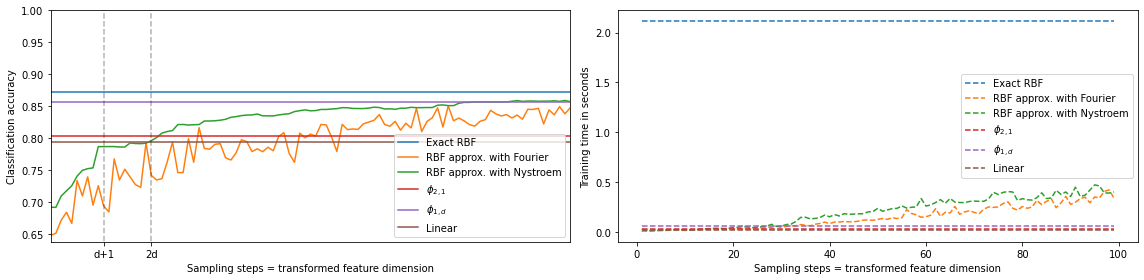

In [5]:
plt.figure(figsize=(16, 4))
accuracy = plt.subplot(121)

# Second y axis for timings
timescale = plt.subplot(122)
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [rbf_score,rbf_score], label="Exact RBF")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [rbf_time, rbf_time], '--', label='Exact RBF')
accuracy.plot(sample_sizes, fourier_scores, label="RBF approx. with Fourier")
timescale.plot(sample_sizes, fourier_times, '--',
               label='RBF approx. with Fourier')
accuracy.plot(sample_sizes, nystroem_scores, label="RBF approx. with Nystroem")
timescale.plot(sample_sizes, nystroem_times, '--',
               label='RBF approx. with Nystroem')
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [linear_map_1_score,linear_map_1_score], label= r'$\phi_{2,1}$')
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [linear_map_1_time, linear_map_1_time], '--', label=r'$\phi_{2,1}$')
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [linear_map_d_score,linear_map_d_score], label=r'$\phi_{1,d}$')
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [linear_map_d_time, linear_map_d_time], '--', label=r'$\phi_{1,d}$')
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [linear_score,linear_score], label="Linear")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [linear_time, linear_time], '--', label='Linear')

# Vertical line for  dimensionality
accuracy.plot([dimension+1, dimension+1], [0, 1],'--',color='black',alpha=0.3)
accuracy.plot([2*dimension, 2*dimension], [0, 1],'--',color='black',alpha=0.3)

# Legends and labels
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
x_ticks=[dimension+1,2*dimension]
x_tick_labels=['d+1','2d']
accuracy.set_xticks(x_ticks)
accuracy.set_xticklabels(x_tick_labels)
accuracy.set_ylim(np.min(fourier_scores)-0.01, 1)
accuracy.set_xlabel("Sampling steps = transformed feature dimension")
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc='best')
timescale.legend(loc='best')
plt.tight_layout()
plt.show()